In [1]:
# Load packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import pickle
import time
import scipy as scp
import scipy.stats as scps
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load my own functions
import dnnregressor_train_eval_keras as dnnk
import make_data_wfpt as mdw
from kde_training_utilities import kde_load_data
import ddm_data_simulation as ddm_sim
import boundary_functions as bf

In [2]:
# Handle some cuda business

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8412095708138727019
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 826017924185342495
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 12048773940
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 2947751280244046591
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:82:00.0, compute capability: 5.2"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15327284663762362847
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
# Load Model
model_path = '/media/data_cifs/afengler/data/kde/linear_collapse/keras_models/dnnregressor_ddm_linear_collapse_06_22_19_23_27_28/model_0' 
ckpt_path = '/media/data_cifs/afengler/data/kde/linear_collapse/keras_models/dnnregressor_ddm_linear_collapse_06_22_19_23_27_28/ckpt_0_130'

model = keras.models.load_model(model_path)
model.load_weights(ckpt_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [ ]:
model.summary()

In [4]:
# Initializations -----
n_runs = 100
n_samples = 2500
feature_file_path = '/media/data_cifs/afengler/data/kde/linear_collapse/train_test_data/test_features.pickle'
mle_out_path = '/media/data_cifs/afengler/data/kde/linear_collapse/mle_runs'

# NOTE PARAMETERS: WEIBULL: [v, a, w, node, shape, scale]
param_bounds = [(-1, 1), (0.3, 2), (0.3, 0.7), (0.01, 0.01), (0, np.pi / 2.2)]


my_optim_columns = ['v_sim', 'a_sim', 'w_sim', 'node_sim', 'theta_sim',
                    'v_mle', 'a_mle', 'w_mle', 'node_mle', 'theta_mle', 'n_samples']

# Get parameter names in correct ordering:
dat = pickle.load(open(feature_file_path, 
                       'rb'))

parameter_names = list(dat.keys())[:-2] # :-1 to get rid of 'rt' and 'choice' here

# Make columns for optimizer result table
p_sim = []
p_mle = []

for parameter_name in parameter_names:
    p_sim.append(parameter_name + '_sim')
    p_mle.append(parameter_name + '_mle')
    
my_optim_columns = p_sim + p_mle + ['n_samples']

# Initialize the data frame in which to store optimizer results
optim_results = pd.DataFrame(np.zeros((n_runs, len(my_optim_columns))), columns = my_optim_columns)
optim_results.iloc[:, 2 * len(parameter_names)] = n_samples

# define boundary
boundary = bf.linear_collapse
boundary_multiplicative = False

# Define the likelihood function
def log_p(params = [0, 1, 0.9], model = [], data = [], parameter_names = []):
    # Make feature array
    feature_array = np.zeros((data[0].shape[0], len(parameter_names) + 2))
    
    # Store parameters
    cnt = 0
    for i in range(0, len(parameter_names), 1):
        feature_array[:, i] = params[i]
        cnt += 1
    
    # Store rts and choices
    feature_array[:, cnt] = data[0].ravel() # rts
    feature_array[:, cnt + 1] = data[1].ravel() # choices
    
    # Get model predictions
    prediction = model.predict(feature_array)
    
    # Some post-processing of predictions
    prediction[prediction < 1e-29] = 1e-29
    
    return(- np.sum(np.log(prediction)))  

def make_params(param_bounds = []):
    params = np.zeros(len(param_bounds))
    
    for i in range(len(params)):
        params[i] = np.random.uniform(low = param_bounds[i][0], high = param_bounds[i][1])
        
    return params
# ---------------------

In [5]:
# Main loop ----------- TD: Parallelize
for i in range(0, n_runs, 1): 
    
    # Get start time
    start_time = time.time()
    
    tmp_params = make_params(param_bounds = param_bounds)
    
    # Store in output file
    optim_results.iloc[i, :len(parameter_names)] = tmp_params
    
    # Print some info on run
    print('Parameters for run ' + str(i) + ': ')
    print(tmp_params)
    
    # Define boundary params
    boundary_params = {'node': tmp_params[3],
                       'theta': tmp_params[4]}
    
    # Run model simulations
    ddm_dat_tmp = ddm_sim.ddm_flexbound_simulate(v = tmp_params[0],
                                                 a = tmp_params[1],
                                                 w = tmp_params[2],
                                                 s = 1,
                                                 delta_t = 0.001,
                                                 max_t = 20,
                                                 n_samples = n_samples,
                                                 boundary_fun = boundary, # function of t (and potentially other parameters) that takes in (t, *args)
                                                 boundary_multiplicative = boundary_multiplicative, # CAREFUL: CHECK IF BOUND
                                                 boundary_params = boundary_params)
        
    # Print some info on run
    print('Mean rt for current run: ')
    print(np.mean(ddm_dat_tmp[0]))
    
    # Run optimizer
    out = differential_evolution(log_p, 
                                 bounds = param_bounds, 
                                 args = (model, ddm_dat_tmp, parameter_names), 
                                 popsize = 30,
                                 disp = True)
    
    # Print some info
    print('Solution vector of current run: ')
    print(out.x)
    
    print('The run took: ')
    elapsed_time = time.time() - start_time
    print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
    # Store result in output file
    optim_results.iloc[i, len(parameter_names):(2*len(parameter_names))] = out.x
# -----------------------

# Save optimization results to file
optim_results.to_csv(mle_out_path + '/mle_results.csv')

Parameters for run 0: 
[-0.62773651  0.52517652  0.65581062  0.01        0.78495368]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
0.15347880000000008
differential_evolution step 1: f(x)= -1297.28
differential_evolution step 2: f(x)= -1423.12
differential_evolution step 3: f(x)= -1423.12
differential_evolution step 4: f(x)= -1424.49
differential_evolution step 5: f(x)= -1424.49
differential_evolution step 6: f(x)= -1441.6
differential_evolution step 7: f(x)= -1493.1
differential_evolution step 8: f(x)= -1493.1
differential_evolution step 9: f(x)= -1493.1
differential_evolution step 10: f(x)= -1494.79
differential_evolution step 11: f(x)= -1496.4
differential_evolution step 12: f(x)= -1496.8
differential_evolution step 13: f(x)= -1502.11
differential_evolution step 14: f(x)= -1502.11
differential_evolution step 15: f(x)= -1503.52
differential_evolution step 16: f(x)= -1503.52
differential_evolution step 17: f(x)= -1503.52
differential_

differential_evolution step 8: f(x)= 1677.66
differential_evolution step 9: f(x)= 1677.66
differential_evolution step 10: f(x)= 1677.66
differential_evolution step 11: f(x)= 1668.09
differential_evolution step 12: f(x)= 1668.09
differential_evolution step 13: f(x)= 1663.31
differential_evolution step 14: f(x)= 1663.31
differential_evolution step 15: f(x)= 1663.31
differential_evolution step 16: f(x)= 1663.31
differential_evolution step 17: f(x)= 1663.31
differential_evolution step 18: f(x)= 1663.31
differential_evolution step 19: f(x)= 1663.31
differential_evolution step 20: f(x)= 1663.31
differential_evolution step 21: f(x)= 1662.67
differential_evolution step 22: f(x)= 1661.5
differential_evolution step 23: f(x)= 1661.5
differential_evolution step 24: f(x)= 1661.5
differential_evolution step 25: f(x)= 1661.5
differential_evolution step 26: f(x)= 1661.27
differential_evolution step 27: f(x)= 1661.27
differential_evolution step 28: f(x)= 1661.27
Solution vector of current run: 
[0.4558

/home/afengler/miniconda3/envs/pytorch/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:901: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5


Solution vector of current run: 
[-0.61782189  1.4907448   0.63133538  0.01        0.23098198]
The run took: 
00:04:04
Parameters for run 8: 
[-0.51263422  1.48481256  0.5629636   0.01        0.66512788]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
0.8182147999999937
differential_evolution step 1: f(x)= 2314.74
differential_evolution step 2: f(x)= 2250.73
differential_evolution step 3: f(x)= 2250.73
differential_evolution step 4: f(x)= 2250.73
differential_evolution step 5: f(x)= 2235.1
differential_evolution step 6: f(x)= 2235.1
differential_evolution step 7: f(x)= 2235.1
differential_evolution step 8: f(x)= 2230.22
differential_evolution step 9: f(x)= 2207.8
differential_evolution step 10: f(x)= 2207.8
differential_evolution step 11: f(x)= 2207.8
differential_evolution step 12: f(x)= 2207.8
differential_evolution step 13: f(x)= 2207.8
differential_evolution step 14: f(x)= 2207.8
differential_evolution step 15: f(x)= 2207.8
differen

differential_evolution step 26: f(x)= 898.943
differential_evolution step 27: f(x)= 898.943
differential_evolution step 28: f(x)= 898.943
Solution vector of current run: 
[0.44030456 1.05814617 0.40279837 0.01       0.8150938 ]
The run took: 
00:05:59
Parameters for run 13: 
[0.01374545 1.36481727 0.62014355 0.01       0.63642748]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
0.7143111999999961
differential_evolution step 1: f(x)= 2262.49
differential_evolution step 2: f(x)= 1988.46
differential_evolution step 3: f(x)= 1988.46
differential_evolution step 4: f(x)= 1988.46
differential_evolution step 5: f(x)= 1976.26
differential_evolution step 6: f(x)= 1975.8
differential_evolution step 7: f(x)= 1975.8
differential_evolution step 8: f(x)= 1975.8
differential_evolution step 9: f(x)= 1958.79
differential_evolution step 10: f(x)= 1958.79
differential_evolution step 11: f(x)= 1958.79
differential_evolution step 12: f(x)= 1958.79
differenti

differential_evolution step 13: f(x)= 2602.35
differential_evolution step 14: f(x)= 2601.91
differential_evolution step 15: f(x)= 2600.03
differential_evolution step 16: f(x)= 2600.03
differential_evolution step 17: f(x)= 2598.13
differential_evolution step 18: f(x)= 2598.13
differential_evolution step 19: f(x)= 2597.61
Solution vector of current run: 
[0.02342231 1.02007479 0.57900834 0.01       0.43795282]
The run took: 
00:04:34
Parameters for run 20: 
[-0.05024534  1.07887587  0.69653311  0.01        1.38215939]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
0.12381120000000008
differential_evolution step 1: f(x)= -3521.91
differential_evolution step 2: f(x)= -3534.4
differential_evolution step 3: f(x)= -3534.4
differential_evolution step 4: f(x)= -3631.54
differential_evolution step 5: f(x)= -3631.54
differential_evolution step 6: f(x)= -3708.57
differential_evolution step 7: f(x)= -3708.57
differential_evolution step 8: f(x)= -37

1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
0.2697220000000002
differential_evolution step 1: f(x)= 150.011
differential_evolution step 2: f(x)= 150.011
differential_evolution step 3: f(x)= 150.011
differential_evolution step 4: f(x)= 134.642
differential_evolution step 5: f(x)= 134.642
differential_evolution step 6: f(x)= 134.642
differential_evolution step 7: f(x)= 134.642
differential_evolution step 8: f(x)= 134.642
differential_evolution step 9: f(x)= 129.077
differential_evolution step 10: f(x)= 128.949
differential_evolution step 11: f(x)= 128.949
differential_evolution step 12: f(x)= 124.782
differential_evolution step 13: f(x)= 124.782
differential_evolution step 14: f(x)= 124.782
differential_evolution step 15: f(x)= 124.782
differential_evolution step 16: f(x)= 122.711
differential_evolution step 17: f(x)= 122.711
differential_evolution step 18: f(x)= 122.711
differential_evolution step 19: f(x)= 122.167
differential_evolution step 20: f(x)= 12

differential_evolution step 6: f(x)= 1659.96
differential_evolution step 7: f(x)= 1659.96
differential_evolution step 8: f(x)= 1656.75
differential_evolution step 9: f(x)= 1656.36
differential_evolution step 10: f(x)= 1656.36
differential_evolution step 11: f(x)= 1655.34
differential_evolution step 12: f(x)= 1655.34
differential_evolution step 13: f(x)= 1655.16
differential_evolution step 14: f(x)= 1654.93
Solution vector of current run: 
[-0.92728002  1.0119373   0.50715787  0.01        0.53181599]
The run took: 
00:03:26
Parameters for run 31: 
[0.56160774 1.40027892 0.68233048 0.01       0.08946894]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
1.088115999999962
differential_evolution step 1: f(x)= 4965.86
differential_evolution step 2: f(x)= 4965.86
differential_evolution step 3: f(x)= 4965.86
differential_evolution step 4: f(x)= 4891.11
differential_evolution step 5: f(x)= 4891.11
differential_evolution step 6: f(x)= 4891.11
diff

differential_evolution step 1: f(x)= -3240.56
differential_evolution step 2: f(x)= -3326.29
differential_evolution step 3: f(x)= -3326.29
differential_evolution step 4: f(x)= -3360.26
differential_evolution step 5: f(x)= -3360.26
differential_evolution step 6: f(x)= -3360.26
differential_evolution step 7: f(x)= -3364.58
differential_evolution step 8: f(x)= -3386.99
differential_evolution step 9: f(x)= -3386.99
differential_evolution step 10: f(x)= -3389.79
differential_evolution step 11: f(x)= -3389.79
differential_evolution step 12: f(x)= -3389.79
differential_evolution step 13: f(x)= -3389.79
differential_evolution step 14: f(x)= -3501.08
differential_evolution step 15: f(x)= -3501.08
differential_evolution step 16: f(x)= -3512.42
differential_evolution step 17: f(x)= -3523.38
differential_evolution step 18: f(x)= -3529.94
differential_evolution step 19: f(x)= -3545.48
differential_evolution step 20: f(x)= -3557.43
differential_evolution step 21: f(x)= -3575.07
differential_evolution

differential_evolution step 3: f(x)= 1675.98
differential_evolution step 4: f(x)= 1675.98
differential_evolution step 5: f(x)= 1637.62
differential_evolution step 6: f(x)= 1625.13
differential_evolution step 7: f(x)= 1625.13
differential_evolution step 8: f(x)= 1625.13
differential_evolution step 9: f(x)= 1625.13
differential_evolution step 10: f(x)= 1621.1
differential_evolution step 11: f(x)= 1621.1
differential_evolution step 12: f(x)= 1621.1
differential_evolution step 13: f(x)= 1620.14
differential_evolution step 14: f(x)= 1619.26
differential_evolution step 15: f(x)= 1617.23
differential_evolution step 16: f(x)= 1617.23
Solution vector of current run: 
[0.23425508 1.15687918 0.35325699 0.01       0.72383548]
The run took: 
00:03:47
Parameters for run 42: 
[-0.31336542  0.96313079  0.37540118  0.01        0.76402669]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
0.35484840000000023
differential_evolution step 1: f(x)= 398.741
dif

differential_evolution step 11: f(x)= 875.932
differential_evolution step 12: f(x)= 875.932
differential_evolution step 13: f(x)= 875.932
differential_evolution step 14: f(x)= 875.932
differential_evolution step 15: f(x)= 875.932
differential_evolution step 16: f(x)= 865.888
differential_evolution step 17: f(x)= 863.718
differential_evolution step 18: f(x)= 863.718
differential_evolution step 19: f(x)= 863.718
differential_evolution step 20: f(x)= 861.619
differential_evolution step 21: f(x)= 861.619
differential_evolution step 22: f(x)= 855.991
differential_evolution step 23: f(x)= 855.991
differential_evolution step 24: f(x)= 855.991
differential_evolution step 25: f(x)= 855.991
differential_evolution step 26: f(x)= 855.991
differential_evolution step 27: f(x)= 855.991
differential_evolution step 28: f(x)= 855.991
differential_evolution step 29: f(x)= 855.072
differential_evolution step 30: f(x)= 855.072
differential_evolution step 31: f(x)= 855.072
differential_evolution step 32: f(

differential_evolution step 25: f(x)= -1095.1
differential_evolution step 26: f(x)= -1095.1
differential_evolution step 27: f(x)= -1095.1
differential_evolution step 28: f(x)= -1095.1
differential_evolution step 29: f(x)= -1095.1
differential_evolution step 30: f(x)= -1095.1
differential_evolution step 31: f(x)= -1095.1
Solution vector of current run: 
[0.98911418 0.79079462 0.4974274  0.01       1.03680308]
The run took: 
00:06:18
Parameters for run 51: 
[0.62432264 0.85453338 0.58000209 0.01       1.35275102]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
0.12270600000000008
differential_evolution step 1: f(x)= -3574.87
differential_evolution step 2: f(x)= -3574.87
differential_evolution step 3: f(x)= -3584.6
differential_evolution step 4: f(x)= -3651.38
differential_evolution step 5: f(x)= -3651.38
differential_evolution step 6: f(x)= -3651.38
differential_evolution step 7: f(x)= -3651.38
differential_evolution step 8: f(x)= -3651.3

differential_evolution step 5: f(x)= -3137.77
differential_evolution step 6: f(x)= -3230.12
differential_evolution step 7: f(x)= -3230.12
differential_evolution step 8: f(x)= -3230.12
differential_evolution step 9: f(x)= -3230.12
differential_evolution step 10: f(x)= -3231.5
differential_evolution step 11: f(x)= -3234.14
differential_evolution step 12: f(x)= -3234.14
differential_evolution step 13: f(x)= -3240.63
differential_evolution step 14: f(x)= -3240.96
differential_evolution step 15: f(x)= -3247.94
differential_evolution step 16: f(x)= -3247.94
differential_evolution step 17: f(x)= -3247.94
differential_evolution step 18: f(x)= -3247.94
differential_evolution step 19: f(x)= -3247.94
Solution vector of current run: 
[-0.66509753  0.44446258  0.60746035  0.01        1.22342557]
The run took: 
00:03:52
Parameters for run 57: 
[0.17107212 1.01245684 0.64948714 0.01       1.07680649]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
0.2

1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
0.1686572000000001
differential_evolution step 1: f(x)= -2873.5
differential_evolution step 2: f(x)= -3626.68
differential_evolution step 3: f(x)= -3626.68
differential_evolution step 4: f(x)= -3626.68
differential_evolution step 5: f(x)= -3626.68
differential_evolution step 6: f(x)= -3626.68
differential_evolution step 7: f(x)= -3635.91
differential_evolution step 8: f(x)= -3669.52
differential_evolution step 9: f(x)= -3669.52
differential_evolution step 10: f(x)= -3669.52
differential_evolution step 11: f(x)= -3696.78
differential_evolution step 12: f(x)= -3700.31
differential_evolution step 13: f(x)= -3725.46
differential_evolution step 14: f(x)= -3725.46
differential_evolution step 15: f(x)= -3725.46
differential_evolution step 16: f(x)= -3725.46
differential_evolution step 17: f(x)= -3725.46
differential_evolution step 18: f(x)= -3749.79
differential_evolution step 19: f(x)= -3749.79
differential_evolution

differential_evolution step 26: f(x)= -217.081
differential_evolution step 27: f(x)= -217.081
differential_evolution step 28: f(x)= -217.081
differential_evolution step 29: f(x)= -217.081
differential_evolution step 30: f(x)= -217.081
differential_evolution step 31: f(x)= -217.081
differential_evolution step 32: f(x)= -217.688
differential_evolution step 33: f(x)= -217.688
differential_evolution step 34: f(x)= -217.688
differential_evolution step 35: f(x)= -217.688
differential_evolution step 36: f(x)= -217.688
differential_evolution step 37: f(x)= -217.688
differential_evolution step 38: f(x)= -217.688
differential_evolution step 39: f(x)= -217.688
differential_evolution step 40: f(x)= -217.688
differential_evolution step 41: f(x)= -217.688
differential_evolution step 42: f(x)= -217.688
differential_evolution step 43: f(x)= -217.688
differential_evolution step 44: f(x)= -217.688
differential_evolution step 45: f(x)= -217.704
Solution vector of current run: 
[-0.9996701   0.71770807  0

differential_evolution step 18: f(x)= -4508
differential_evolution step 19: f(x)= -4508.92
Solution vector of current run: 
[-0.44834031  0.55793343  0.44804861  0.01        1.38416021]
The run took: 
00:03:54
Parameters for run 73: 
[0.71575033 1.18859098 0.65631431 0.01       1.10845005]
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
Mean rt for current run: 
0.27226680000000025
differential_evolution step 1: f(x)= -1076.12
differential_evolution step 2: f(x)= -1076.12
differential_evolution step 3: f(x)= -1095.55
differential_evolution step 4: f(x)= -1246.3
differential_evolution step 5: f(x)= -1246.3
differential_evolution step 6: f(x)= -1246.3
differential_evolution step 7: f(x)= -1246.3
differential_evolution step 8: f(x)= -1246.3
differential_evolution step 9: f(x)= -1246.3
differential_evolution step 10: f(x)= -1246.3
differential_evolution step 11: f(x)= -1255.67
differential_evolution step 12: f(x)= -1255.67
differential_evolution step 13: f(x)= -1255

differential_evolution step 2: f(x)= -201.469
differential_evolution step 3: f(x)= -201.469
differential_evolution step 4: f(x)= -214.199
differential_evolution step 5: f(x)= -217.371
differential_evolution step 6: f(x)= -217.371
differential_evolution step 7: f(x)= -217.371
differential_evolution step 8: f(x)= -217.371
differential_evolution step 9: f(x)= -217.434
differential_evolution step 10: f(x)= -234.6
differential_evolution step 11: f(x)= -234.6
differential_evolution step 12: f(x)= -234.6
differential_evolution step 13: f(x)= -234.6
differential_evolution step 14: f(x)= -234.6
differential_evolution step 15: f(x)= -234.6
differential_evolution step 16: f(x)= -234.6
differential_evolution step 17: f(x)= -234.6
differential_evolution step 18: f(x)= -234.6
differential_evolution step 19: f(x)= -234.6
differential_evolution step 20: f(x)= -234.6
differential_evolution step 21: f(x)= -234.6
differential_evolution step 22: f(x)= -234.724
differential_evolution step 23: f(x)= -234.72

differential_evolution step 21: f(x)= -3305.73
differential_evolution step 22: f(x)= -3305.73
differential_evolution step 23: f(x)= -3305.73
differential_evolution step 24: f(x)= -3317.19
differential_evolution step 25: f(x)= -3317.19
differential_evolution step 26: f(x)= -3332.33
differential_evolution step 27: f(x)= -3332.33
differential_evolution step 28: f(x)= -3332.33
differential_evolution step 29: f(x)= -3332.33
differential_evolution step 30: f(x)= -3332.33
differential_evolution step 31: f(x)= -3332.36
differential_evolution step 32: f(x)= -3332.36
differential_evolution step 33: f(x)= -3334.29
differential_evolution step 34: f(x)= -3334.29
differential_evolution step 35: f(x)= -3334.29
differential_evolution step 36: f(x)= -3334.29
differential_evolution step 37: f(x)= -3334.29
differential_evolution step 38: f(x)= -3334.29
differential_evolution step 39: f(x)= -3334.93
differential_evolution step 40: f(x)= -3334.93
differential_evolution step 41: f(x)= -3336.26
differential_

differential_evolution step 5: f(x)= 410.74
differential_evolution step 6: f(x)= 330.745
differential_evolution step 7: f(x)= 327.886
differential_evolution step 8: f(x)= 305.057
differential_evolution step 9: f(x)= 305.057
differential_evolution step 10: f(x)= 305.057
differential_evolution step 11: f(x)= 305.057
differential_evolution step 12: f(x)= 305.057
differential_evolution step 13: f(x)= 305.057
differential_evolution step 14: f(x)= 305.057
differential_evolution step 15: f(x)= 305.057
differential_evolution step 16: f(x)= 305.057
differential_evolution step 17: f(x)= 305.057
differential_evolution step 18: f(x)= 304.762
differential_evolution step 19: f(x)= 303.85
differential_evolution step 20: f(x)= 303.85
differential_evolution step 21: f(x)= 303.85
differential_evolution step 22: f(x)= 303.85
differential_evolution step 23: f(x)= 302.977
differential_evolution step 24: f(x)= 302.977
differential_evolution step 25: f(x)= 302.977
differential_evolution step 26: f(x)= 302.43

Mean rt for current run: 
0.5219143999999976
differential_evolution step 1: f(x)= 1168.97
differential_evolution step 2: f(x)= 1168.97
differential_evolution step 3: f(x)= 1168.97
differential_evolution step 4: f(x)= 1166.1
differential_evolution step 5: f(x)= 1166.1
differential_evolution step 6: f(x)= 1139.98
differential_evolution step 7: f(x)= 1138.69
differential_evolution step 8: f(x)= 1138.5
differential_evolution step 9: f(x)= 1138.5
differential_evolution step 10: f(x)= 1138.5
differential_evolution step 11: f(x)= 1135.73
differential_evolution step 12: f(x)= 1135.37
differential_evolution step 13: f(x)= 1135.37
differential_evolution step 14: f(x)= 1135.37
differential_evolution step 15: f(x)= 1133.6
differential_evolution step 16: f(x)= 1133.6
Solution vector of current run: 
[-0.75353415  0.96678402  0.41136648  0.01        0.53774758]
The run took: 
00:03:44
Parameters for run 93: 
[-0.94771385  1.96269941  0.40933261  0.01        0.14995792]
0  datapoints sampled
1000  da

differential_evolution step 17: f(x)= -4132.52
differential_evolution step 18: f(x)= -4132.52
differential_evolution step 19: f(x)= -4132.52
differential_evolution step 20: f(x)= -4132.52
differential_evolution step 21: f(x)= -4132.57
differential_evolution step 22: f(x)= -4163.62
differential_evolution step 23: f(x)= -4163.62
differential_evolution step 24: f(x)= -4178.19
differential_evolution step 25: f(x)= -4178.19
differential_evolution step 26: f(x)= -4178.19
differential_evolution step 27: f(x)= -4178.19
differential_evolution step 28: f(x)= -4178.19
differential_evolution step 29: f(x)= -4180.47
differential_evolution step 30: f(x)= -4183.62
differential_evolution step 31: f(x)= -4183.62
differential_evolution step 32: f(x)= -4183.67
differential_evolution step 33: f(x)= -4184.11
differential_evolution step 34: f(x)= -4189.28
differential_evolution step 35: f(x)= -4189.28
differential_evolution step 36: f(x)= -4189.28
Solution vector of current run: 
[0.85675778 0.88412955 0.37

In [6]:
# Read in results
optim_results = pd.read_csv(mle_out_path + '/mle_results.csv')

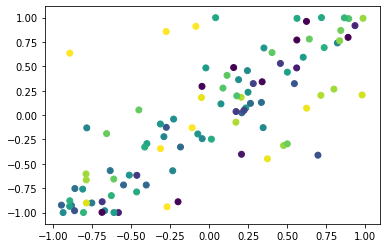

In [8]:
plt.scatter(optim_results['v_sim'], optim_results['v_mle'], c = optim_results['theta_mle'])

In [9]:
# Regression for v
reg = LinearRegression().fit(np.expand_dims(optim_results['v_mle'], 1), np.expand_dims(optim_results['v_sim'], 1))
reg.score(np.expand_dims(optim_results['v_mle'], 1), np.expand_dims(optim_results['v_sim'], 1))

0.617887802768772

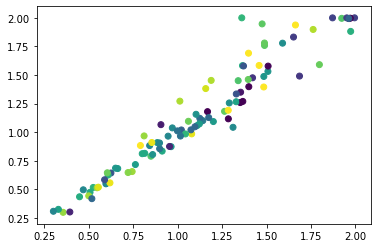

In [11]:
plt.scatter(optim_results['a_sim'], optim_results['a_mle'], c = optim_results['theta_mle'])

In [12]:
# Regression for a
reg = LinearRegression().fit(np.expand_dims(optim_results['a_mle'], 1), np.expand_dims(optim_results['a_sim'], 1))
reg.score(np.expand_dims(optim_results['a_mle'], 1), np.expand_dims(optim_results['a_sim'], 1))

0.9278981038056895

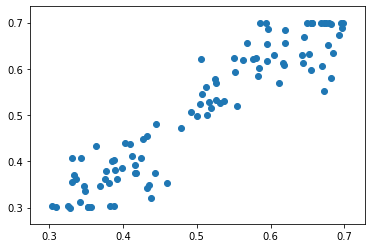

In [13]:
plt.scatter(optim_results['w_sim'], optim_results['w_mle'])

In [14]:
# Regression for w
reg = LinearRegression().fit(np.expand_dims(optim_results['w_mle'], 1), np.expand_dims(optim_results['w_sim'], 1))
reg.score(np.expand_dims(optim_results['w_mle'], 1), np.expand_dims(optim_results['w_sim'], 1))

0.8762772986396704

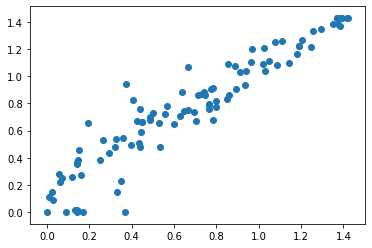

In [15]:
plt.scatter(optim_results['theta_sim'], optim_results['theta_mle'])

In [17]:
# Regression for c1
reg = LinearRegression().fit(np.expand_dims(optim_results['theta_mle'], 1), np.expand_dims(optim_results['theta_sim'], 1))
reg.score(np.expand_dims(optim_results['theta_mle'], 1), np.expand_dims(optim_results['theta_sim'], 1))

0.8890366364460973

In [ ]:
plt.scatter(optim_results['c2_sim'], optim_results['c2_mle'], c = optim_results['a_mle'])

In [ ]:
# Regression for w
reg = LinearRegression().fit(np.expand_dims(optim_results['c2_mle'], 1), np.expand_dims(optim_results['c2_sim'], 1))
reg.score(np.expand_dims(optim_results['c2_mle'], 1), np.expand_dims(optim_results['c2_sim'], 1))